In [ ]:
#@title Install Required Packages: proplot,cartopy,drpy

%%capture
!pip -q uninstall shapely --yes
!pip -q install shapely cartopy==0.18.0 --no-binary shapely --no-binary cartopy==0.18.0
!pip -q install git+https://github.com/dopplerchase/DRpy.git
!pip -q install proplot
!pip -q install pyproj 

In [ ]:
#@title Import Required Packages
import pandas as pd 
import drpy 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#@title JAXA NRT INFO BOX 
#@markdown To make things easy, paste the closest jaxa waypoint info here!
jaxa_waypoint = '2021/04/22 11:48:00 Lat:\t36.766 Lon:\t172.994 Orbit No.:\t(040615)' #@param {type:"string"}
dtime = pd.to_datetime(jaxa_waypoint.split('Lat')[0])
lat_r = float(jaxa_waypoint.split('Lat:\t')[1].split('Lon')[0])
lon_r = float(jaxa_waypoint.split('Lat:\t')[1].split('Lon:\t')[1].split()[0])
if lon_r > 180:
  lon_r = lon_r - 360 
# orbit_n = int(jaxa_waypoint.split('Lat:\t')[1].split('Lon:\t')[1].split()[3])
# lon_r,lat_r

In [ ]:
io = drpy.io.netrunner(servername='NearRealTime',username='randyjc2@illinois.edu',start_time=dtime,Xradar=False)

Downloading: https://jsimpsonhttps.pps.eosdis.nasa.gov/text/radar/DprL2/2A.GPM.DPR.V820180723.20210422-S114128-E121127.V06A.RT-H5
Done


In [ ]:
filename = io.filename[0][-57:]
# filename = io.filename[0][-64:]
# filename = './2A.GPM.DPRX.V8-20200326.20210420-S003639-E020912.040577.V06X.HDF5'
# c = case_study(filename=filename,center_lat=lat_r,center_lon=lon_r)
# self = c
c = drpy.graph.case_study(filename=filename,center_lat=lat_r,center_lon=lon_r)
# c.plotter(start_index=75,end_index=-75,scan=29,params_new={'y_max':15,'z_vmax':50,'xsections':[1,3,5]})
# c.plotter(start_index=25,end_index=-25,scan=45,params_new={'y_max':15,'z_vmax':50,'xsections':[0,2,4]})

In [ ]:
import matplotlib.cm as cmx
import matplotlib.colors as colors 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patheffects as PathEffects
import cartopy.io.shapereader as shpreader
import pandas as pd 
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

def make_colorbar(ax,vmin,vmax,cmap):
    cNorm  = colors.Normalize(vmin=vmin, vmax=vmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                              norm=cNorm,
                              orientation='horizontal',extend='both')
    return cb1

class case_study:

  def __init__(self,filename=None,center_lat=None,center_lon=None):

    import drpy 
    dpr = drpy.core.GPMDPR(filename=filename,outer_swath=True,auto_run=False)
    dpr.read()
    dpr.calc_heights()
    dpr.toxr(clutter=False,echotop=False)
    corners = [center_lon - 5,center_lon + 5,center_lat-5,center_lat+5]
    dpr.corners = corners
    dpr.setboxcoords()
    #drop dead weight (i.e. blank data)
    dpr.xrds = dpr.xrds.dropna(dim='along_track',how='all')
    self.dpr = dpr

  def plotter(self,start_index=25,end_index=-25,scan=24,params_new=None):

    if params_new is None:
      params = {'z_vmin':10,'z_vmax':40,'y_max':10,'dfr_vmin':-2,'dfr_vmax':10,
                'dm_vmin':0,'dm_vmax':2,'nw_vmin':1,'nw_vmax':6,'r_vmin':-1,'r_vmax':2,
                'xsections':[0,2,4]}
    else:
      params = {'z_vmin':10,'z_vmax':40,'y_max':10,'dfr_vmin':-2,'dfr_vmax':10,
                'dm_vmin':0,'dm_vmax':2,'nw_vmin':1,'nw_vmax':6,'r_vmin':-1,'r_vmax':2,
                'xsections':[0,2,4]}
      keys_old = list(params.keys())
      keys = list(params_new.keys())
      for key in keys: 
        for i in keys_old:
                if key in i:
                  params[key] = params_new[key]


    import proplot as plot
    #plot parameters that I personally like, feel free to make these your own.
    matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['xtick.labelsize'] = 12
    matplotlib.rcParams['ytick.labelsize'] = 12
    matplotlib.rcParams['legend.fontsize'] = 12
    matplotlib.rcParams['legend.facecolor'] = 'w'
    matplotlib.rcParams['savefig.transparent'] = False

    #determine center
    s = 0 
    e = self.dpr.xrds.lons.shape[0]
    middle = int((e-s)/2)
    lon0 = self.dpr.xrds.lons.values[middle,24]
    lat0 = self.dpr.xrds.lats.values[middle,24]
    #set specific aspect for cartopy plot
    x = 7.5
    y = 0.6666666*x
    corners = [lon0-x,lon0+x,lat0-y,lat0+y]

    #draw axes with proplot
    array = [  # the "picture" (1 == subplot A, 2 == subplot B, etc.)
    [1,1,1,0,0,0,0],
    [1,1,1, 4,4,4,4],
    [2,2,2,4,4,4,4],
    [2,2,2,4,4,4,4],
    [3,3,3,4,4,4,4],
    [3,3,3,0,0,0,0]]
    fig, axs = plot.subplots(array, width=10,height=5,span=False,proj={4:'cyl'},tight=False)
    fig.set_facecolor('w')

    #do things to map subplot 
    ax = axs[3]
    ax.format(borderscolor='k',gridminor=True,
              borders=True,lonlabels='t', latlabels='l',
              lonlim=(corners[0], corners[1]), latlim=(corners[2], corners[3]))
    
    #manually adjust map location to make it fit nicely 
    box = ax.get_position()
    box.y0 = box.y0 - 0.05
    box.y1 = box.y1 - 0.05
    box.x0 = box.x0 + 0.01
    box.x1 = box.x1 + 0.01
    ax.set_position(box)
    #add land and ocean colors
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'),facecolor=[0.9,0.9,0.9])
    ax.add_feature(cartopy.feature.OCEAN.with_scale('50m'))
    plt.setp(ax.spines.values(), color='orangered',lw=2)

    #plot swath (descending) **Need to have this autodetect which orbit
    ax.plot(self.dpr.xrds.lons[:,0]+0.0485,self.dpr.xrds.lats[:,0],'--k')
    ax.plot(self.dpr.xrds.lons[:,-1]-0.0485,self.dpr.xrds.lats[:,-1],'--k')

    #grab the closest non-clutter gates 
    self.dpr.extract_nearsurf()

    #plot data on map 
    pm = ax.scatter(self.dpr.xrds.lons[:,:],self.dpr.xrds.lats[:,:],c=self.dpr.xrds.nearsurfaceKu[:,:],vmin=params['z_vmin'],vmax=params['z_vmax'],s=1,cmap='Spectral_r',linewidths=0.1,zorder=10)
    s = start_index
    e = end_index
    w = scan

    #plot the along_track choice
    ax.plot(self.dpr.xrds.lons[s:e,w],self.dpr.xrds.lats[s:e,w],'-k',markerfacecolor='w',ms=10,zorder=12)
    ax.plot(self.dpr.xrds.lons[s,w],self.dpr.xrds.lats[s,w],'k',markerfacecolor='w',ms=10,label='Start',marker='$L$',markeredgewidth=1,zorder=12)
    ax.plot(self.dpr.xrds.lons[e,w],self.dpr.xrds.lats[e,w],'k',markerfacecolor='w',ms=10,label='End',marker='$R$',markeredgewidth=1,zorder=12)

    #add coastlines 
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('50m'),color='k',zorder=11)

    #add zoomed out map for context using proplot
    inset_axis = ax.inset([0.575,-0.4,0.5,0.5],proj='cyl',zoom=False,zorder=11)
    inset_axis.format(land=True,landcolor=[0.9,0.9,0.9],borderscolor='k',gridminor=True)
    inset_axis.add_feature(cartopy.feature.OCEAN.with_scale('50m'))
    inset_axis.plot(self.dpr.xrds.lons[:,0]+0.0485,self.dpr.xrds.lats[:,0],'--k',lw=0.5,)
    inset_axis.plot(self.dpr.xrds.lons[:,-1]-0.0485,self.dpr.xrds.lats[:,-1],'--k',lw=0.5,)
    inset_axis.plot([corners[0],corners[0],corners[1],corners[1],corners[0]],[corners[2],corners[3],corners[3],corners[2],corners[2]],'-',color='orangered')
    timestr = pd.to_datetime(self.dpr.xrds.time[middle,24].values).strftime(format='%Y-%m-%d %H:%M')
    text = inset_axis.text(-0.05,-0.2,'Scan Time: ' + timestr,transform=ax.transAxes,fontsize=10)
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="w")])
    text = inset_axis.text(0.025,-0.275,'Created with DRpy',transform=ax.transAxes,fontsize=10)
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="w")])

    #draw colorbars in better spot (above map)
    ax_cbar = fig.add_axes([0.6, 0.93, 0.33, 0.015])
    text = ax_cbar.text(-0.25,0,'$Z_{e}$, [$dBZ$]',fontsize=10,transform=ax_cbar.transAxes)
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="w")])
    cb1 = make_colorbar(ax_cbar,params['z_vmin'],params['z_vmax'],plt.cm.Spectral_r)
    ax_cbar = fig.add_axes([0.6, 0.85, 0.33, 0.015])
    text = ax_cbar.text(-0.33,0,'$DFR_{Ku-Ka}$, [$dB$]',fontsize=10,transform=ax_cbar.transAxes)
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="w")])
    cb2 = make_colorbar(ax_cbar,-2,10,cmaps.turbo)

    #get distances to plot cross-section 
    self.dpr.get_physcial_distance(reference_point=[self.dpr.xrds.lons.values[s,w],self.dpr.xrds.lats.values[s,w]])

    for i in np.arange(0,3):
      ax = axs[i]
      cross_section_method(params['xsections'][i],s,e,w,ax,params)
      
    ax.set_xlabel('Along Track Distance, [km]',labelpad=8)

    # plt.savefig('GPM_Example.png',dpi=500)

In [ ]:
#xsection choice key
# 0  raw Ku band 
# 1  corrected Ku band 
# 2  raw Ka band 
# 3  corrected Ka band 
# 4  raw DFR (rawKu - rawKa)
# 5  corrected DFR (Ku - Ka)
# 6  retrieved R (2A.DPR method)
# 7  retrieved Dm (2A.DPR method)
# 8  retreived Nw (2A.DPR method)

In [ ]:
def cross_section_method(choice,s,e,w,ax,params): 
  if choice ==0:
    x = self.dpr.xrds.NSKu.where(self.dpr.xrds.NSKu >= 10)
    cmap = 'Spectral_r'
    levels=np.linspace(params['z_vmin'], params['z_vmax'], 50)
    vmin = params['z_vmin']
    vmax = params['z_vmax']
    label = 'KuPR'
  elif choice==1:
    x = self.dpr.xrds.NSKu_c.where(self.dpr.xrds.NSKu_c >= 10)
    cmap = 'Spectral_r'
    levels=np.linspace(params['z_vmin'], params['z_vmax'], 50)
    vmin = params['z_vmin']
    vmax = params['z_vmax']
    label = 'KuPR_c'
  elif choice==2:
    x = self.dpr.xrds.MSKa.where(self.dpr.xrds.MSKa >= 15)
    cmap = 'Spectral_r'
    levels=np.linspace(params['z_vmin'], params['z_vmax'], 50)
    vmin = params['z_vmin']
    vmax = params['z_vmax']
    label = 'KaPR'
  elif choice==3:
    x = self.dpr.xrds.MSKa_c.where(self.dpr.xrds.MSKa_c >= 15)
    cmap = 'Spectral_r'
    levels=np.linspace(params['z_vmin'], params['z_vmax'], 50)
    vmin = params['z_vmin']
    vmax = params['z_vmax']
    label = 'KaPR_c'
  elif choice==4:
    x = self.dpr.xrds.NSKu.where(self.dpr.xrds.NSKu >= 10) - self.dpr.xrds.MSKa.where(self.dpr.xrds.MSKa >= 15)
    cmap = cmaps.turbo
    levels=np.linspace(params['dfr_vmin'], params['dfr_vmax'], 50)
    vmin = params['dfr_vmin']
    vmax = params['dfr_vmax']
    label = 'DFR'
  elif choice==5:
    x = self.dpr.xrds.NSKu_c.where(self.dpr.xrds.NSKu_c >= 10) - self.dpr.xrds.MSKa_c.where(self.dpr.xrds.MSKa_c >= 15)
    cmap = cmaps.turbo
    levels=np.linspace(params['dfr_vmin'], params['dfr_vmax'], 50)
    vmin = params['dfr_vmin']
    vmax = params['dfr_vmax']
    label = 'DFR_c'
  elif choice==6:
    x = self.dpr.xrds.Dm_dpr.where(self.dpr.xrds.NSKu_c >= 10) 
    cmap = cmaps.plasma
    levels=np.linspace(params['dm_vmin'], params['dm_vmax'], 50)
    vmin = params['dm_vmin']
    vmax = params['dm_vmax']
    label = 'Dm_2ADPR'
  elif choice==7:
    x = self.dpr.xrds.Nw_dpr.where(self.dpr.xrds.NSKu_c >= 10)/10 #convert to log(mm^-1 m^-3)
    cmap = cmaps.plasma
    levels=np.linspace(params['nw_vmin'], params['nw_vmax'], 50)
    vmin = params['nw_vmin']
    vmax = params['nw_vmax']
    label = 'Nw_2ADPR'
  elif choice==8:
    x = self.dpr.xrds.R.where(self.dpr.xrds.NSKu_c >= 10) 
    x = x.where(x > 0)
    x = np.log10(x)
    cmap = cmaps.plasma
    levels=np.linspace(params['r_vmin'], params['r_vmax'], 50)
    vmin = params['r_vmin']
    vmax = params['r_vmax']
    label = 'R_2ADPR'

  pm = ax.pcolormesh(self.dpr.xrds.distance.values[s:e,w],self.dpr.xrds.NSKu.alt.values[s,w,:],x.values[s:e,w,:].T,cmap=cmap,vmin=vmin,vmax=vmax,levels=levels)
  ax.set_ylim([0,params['y_max']])
  text = ax.text(0.025,0.85,label,fontsize=12,transform=ax.transAxes)
  text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="w")])    



In [ ]:
from drpy.graph import cmaps

In [ ]:
list(c.dpr.hdf['HS'])

['ScanTime',
 'scanStatus',
 'navigation',
 'PRE',
 'VER',
 'CSF',
 'SRT',
 'DSD',
 'Experimental',
 'SLV',
 'FLG',
 'Latitude',
 'Longitude']

In [ ]:
z = c.dpr.hdf['HS']['PRE']['zFactorMeasured'][:,:,:]
z[z<= 12] = np.nan
lats = c.dpr.hdf['HS']['Latitude'][:]
lons = c.dpr.hdf['HS']['Longitude'][:]

reference_point = [-75.3,-12.0]
from pyproj import Proj
p = Proj(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=reference_point[1], lon_0=reference_point[0])

x,y = p(lons,lats)
dist = np.sqrt(x**2 + y**2)/1000.
np.where(dist < 5)

(array([1693, 1693, 1694, 1694]), array([17, 18, 17, 18]))

In [ ]:
c.dpr.xrds.alt

<xarray.DataArray 'alt' (along_track: 284, cross_track: 49, range: 176)>
array([[[20.86307104, 20.74453086, 20.62599068, ...,  0.35562053,
          0.23708035,  0.11854018],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        ...,
        [21.12357123, 21.00355094, 20.88353065, ...,  0.36006087,
          0.24004058,  0.12002029],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467]],

       [[20.86307104, 20.74453086, 20.62599068, ...,  0.35562053,
          0.23708035,  0.11854018],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        ...,
        [21.12357123, 21.00355094, 20.88353065, ...,  0.36006087,
          0.24004058,  0.12002029],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467]],

       [[20.86307104, 20.74453086, 20.62599068, ...,  0.35562053,
          0.23708035,  0.11854018],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        ...,
        [21.12357123, 21.00355094, 20.88353065, ...,  0.36006087,
          0.24004058,  0.12002029],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467]],

       ...,

       [[20.86307104, 20.74453086, 20.62599068, ...,  0.35562053,
          0.23708035,  0.11854018],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        ...,
        [21.12357123, 21.00355094, 20.88353065, ...,  0.36006087,
          0.24004058,  0.12002029],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467]],

       [[20.86307104, 20.74453086, 20.62599068, ...,  0.35562053,
          0.23708035,  0.11854018],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        ...,
        [21.12357123, 21.00355094, 20.88353065, ...,  0.36006087,
          0.24004058,  0.12002029],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467]],

       [[20.86307104, 20.74453086, 20.62599068, ...,  0.35562053,
          0.23708035,  0.11854018],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        ...,
        [21.12357123, 21.00355094, 20.88353065, ...,  0.36006087,
          0.24004058,  0.12002029],
        [21.04045749, 20.92090944, 20.80136138, ...,  0.35864416,
          0.23909611,  0.11954805],
        [20.95362177, 20.8345671 , 20.71551243, ...,  0.35716401,
          0.23810934,  0.11905467]]])
Coordinates:
    lons     (along_track, cross_track) float32 168.31897 168.37082 ... 178.3797
    lats     (along_track, cross_track) float32 31.774897 

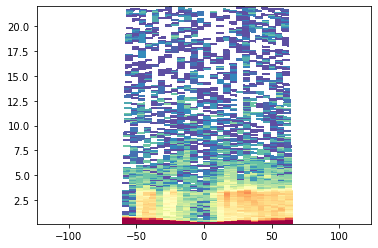

In [ ]:
import copy 

scan_angles = np.deg2rad(np.linspace(-17,17,49)) #assuming linear spacing in radians
scan_angles = np.tile(scan_angles[:,np.newaxis],(1,176)) 
# _range = np.arange(1,177)*250
y =  405 - copy.deepcopy(c.dpr.xrds.alt[0,:,:].values)
x_coords= copy.deepcopy(y*np.tan(scan_angles))
# plt.ylim([0,405])
plt.pcolormesh(x_coords,c.dpr.xrds.alt[0,:,:].values,c.dpr.xrds.MSKa[101,:,:].values,vmin=10,vmax=40,cmap='Spectral_r')
# _range.shape,scan_angles.shape

In [ ]:
# xr.DataArray(data = c.dpr.xrds.NSKu[100:110,:,:].values,dims=['ani','x','y'],coords={'x':,})
# x_coords.shape


(49, 176)

In [ ]:
z = c.dpr.hdf['MS']['PRE']['zFactorMeasured'][:,:,:]
z[z<= 18] = np.nan
lats = c.dpr.hdf['MS']['Latitude'][:]
lons = c.dpr.hdf['MS']['Longitude'][:]

reference_point = [-75.3,-12.0]
from pyproj import Proj
p = Proj(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=reference_point[1], lon_0=reference_point[0])

x,y = p(lons,lats)
dist = np.sqrt(x**2 + y**2)/1000.
np.where(dist < 5)

(array([1694, 1694, 1694, 1695]), array([17, 18, 19, 18]))

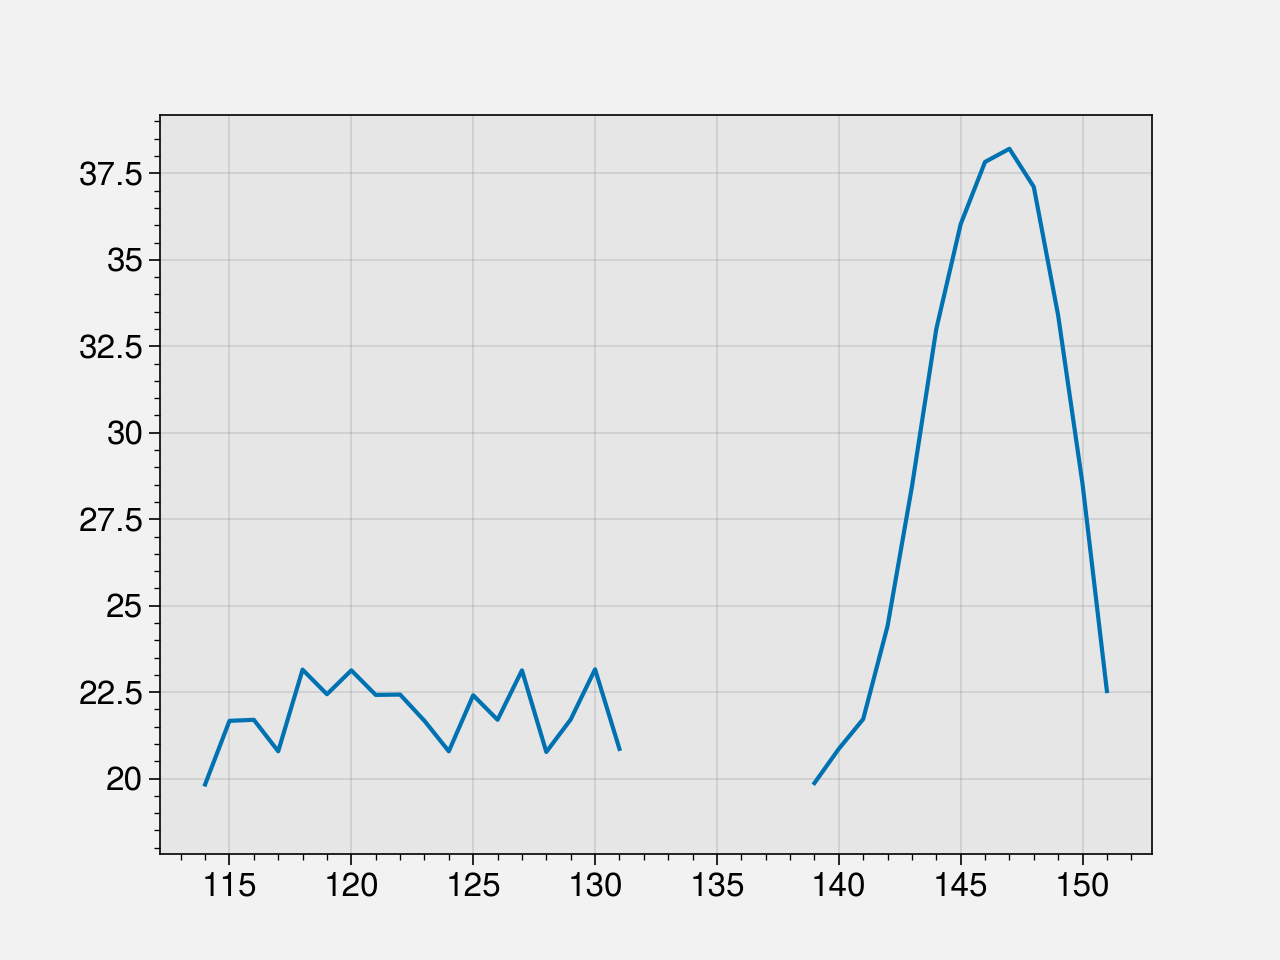

In [ ]:
plt.plot(z[1693,17,:])

Populating the interactive namespace from numpy and matplotlib


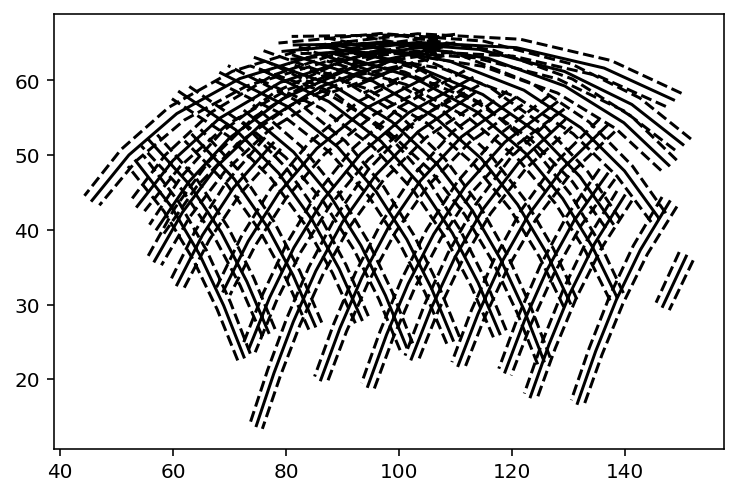

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/dopplerchase/WeatherScripts/master/dpr_forecast_tracks.txt',delim_whitespace=True,header=None)
df = df.where(df[3] > -999)
%pylab inline
%config InlineBackend.figure_format = 'retina'
plt.plot(df[2],df[1],'-k')
plt.plot(df[5],df[4],'--k')
plt.plot(df[7],df[6],'--k')

In [ ]:
# Function used to create the map subplots
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

# crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
crs = ccrs.PlateCarree()
def plot_background(ax):
    ax.set_extent([235., 290., 20., 55.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

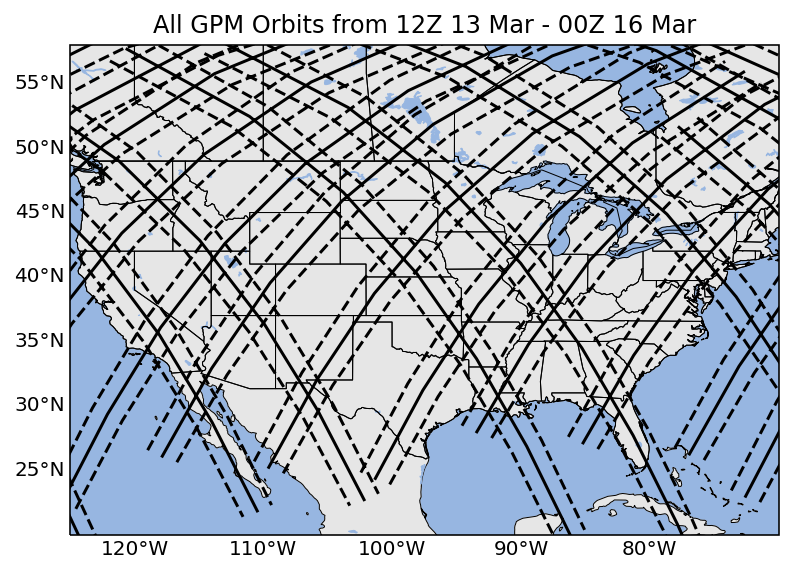

In [ ]:
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator,LongitudeLocator)
import matplotlib.ticker as mticker
# Create the figure and plot background on different axes
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([235., 290., 20., 55.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, linewidth=0.5)
ax.add_feature(cfeature.LAND, linewidth=0.5,facecolor=[0.9,0.9,0.9])
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# plot_background(axarr)
ax.plot(-1*df[2].values[33:],df[1].values[33:],'-k', transform=ccrs.PlateCarree(),zorder=10)
ax.plot(-1*df[5].values[33:],df[4].values[33:],'--k')
ax.plot(-1*df[7].values[33:],df[6].values[33:],'--k')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray',)
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True 
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()


ax.set_title('All GPM Orbits from 12Z 13 Mar - 00Z 16 Mar')
plt.savefig('GPM_Example.png',dpi=500,bbox_inches='tight')

In [ ]:
from google.colab import files
files.download('GPM_Example.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
c.dpr.xrds.alt[0,:,:].values.max()

21.99952434439146

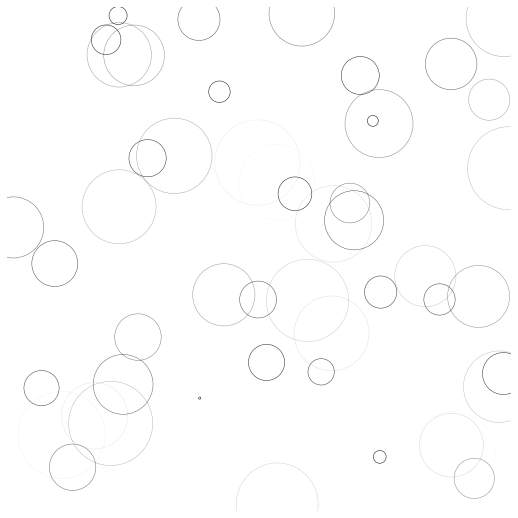

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, (2,)),
                                      ('size',     float),
                                      ('growth',   float),
                                      ('color',    float, (4,))])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation director.
animation = FuncAnimation(fig, update, interval=10)
animation